In [1]:
import numpy as np
import astropy.constants as const
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda
from astropy.io.ascii import read 
from scipy.interpolate import interp1d
from scipy.integrate import trapz
import seaborn as sea
import matplotlib.pyplot as plt
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
%matplotlib inline

In [2]:
# read U,B,V filter transimission functions 
filter_rows = np.loadtxt('UBV_ma06.txt', delimiter=',', skiprows=17, unpack=True, dtype=str)

In [3]:
# read in kurucz model information -- for stars
from astropy.io import fits
filepath = 'kp00/kp00_'
spec_types = ['M0V', 'K5V', 'K0V', 'G5V', 'F5V', 'F0V', 'A5V', 'A0V', 'B8V', 'B3V']
temp = ['3750', '4250', '5250', '5750', '6500', '7250', '8250', '9500', '12000', '19000']
g = ['g45', 'g45', 'g45', 'g45', 'g40', 'g40', 'g45', 'g40', 'g40', 'g40'] # recommended log g

In [4]:
# unpack into various filters and wavelength ranges - ignore zeros 
colnum = 6
lam_u = np.array([float(row.split(' ', colnum)[0]) for row in filter_rows])
lam_b = np.array([float(row.split(' ', colnum)[2]) for row in filter_rows])
lam_v = np.array([float(row.split(' ', colnum)[4]) for row in filter_rows])

good_u = np.where(lam_u != 0)
good_b = np.where(lam_b != 0)
good_v = np.where(lam_v != 0)

filteru = [float(row.split(' ', colnum)[1]) for row in filter_rows[good_u]]
filterb = [float(row.split(' ', colnum)[3]) for row in filter_rows[good_b]]
filterv = [float(row.split(' ', colnum)[5]) for row in filter_rows[good_v]]

In [5]:
# select wavelength ranges where filter is defined
lam_u = lam_u[good_u] # in Angstroms
lam_b = lam_b[good_b] 
lam_v = lam_v[good_v] 
lam_arr = [lam_u, lam_b, lam_v]

Text(0,0.5,'$\\phi(\\lambda)\\; (photons\\; s^{-1}\\; cm^{-2}\\; \\AA^{-1})$')

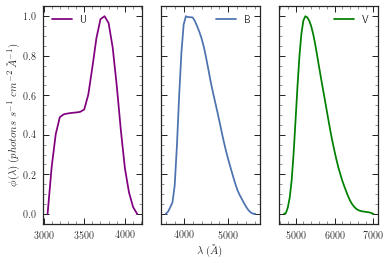

In [65]:
# figure out what units the sensitivities are in -- not so clear from the file header 
fig, ax = plt.subplots(1,3)
ax[0].plot(lam_u, filteru, label='U', color='purple')
ax[0].legend()
ax[1].plot(lam_b, filterb, label='B')
ax[1].set_yticklabels([])
ax[1].legend()
ax[2].plot(lam_v, filterv, label='V', color='green')
ax[2].set_yticklabels([])
ax[2].legend()
ax[1].set_xlabel('$\lambda\; (\AA)$')
ax[0].set_ylabel('$\phi(\lambda)\; (photons\; s^{-1}\; cm^{-2}\; \AA^{-1})$')

In [7]:
# interpolate filter sensitivities over same wavelength range as a generic star's spectrum
wavelengths = fits.open(filepath+temp[0]+'.fits')[1].data['wavelength'] 
filter_arr  = [filteru, filterb, filterv]
filter_obj = [interp1d(lam, tlambda, fill_value=0, bounds_error = False) 
              for lam, tlambda in zip(lam_arr, filter_arr)]
fsens = [obj(wavelengths) for obj in filter_obj]

In [8]:
# weight sensitivities by photon energy
t_lambda = [(tsens*wavelengths/(const.h*const.c)).value for tsens in fsens]

In [66]:
# Vega - AB conversion factors (U,B,V)
offset = [0.8, -0.11, 0] 
# solid angle of a 1m telescope (from http://www.atnf.csiro.au/people/Tobias.Westmeier/tools_spherical.php)
omega_corr = 384.37 # using IMACS spectrograph on the 6.5 mBaade telescope at Las Campanas Observatory. 

In [67]:
def bbcurve(wavelengths, temp):  
    # calculate source function for blackbody in each filter 
    with np.errstate(all='ignore'): # may spit out nans or inf so we want to ignore those warnings
        slam = blackbody_lambda(wavelengths, temp).value*omega_corr     
    return slam

def abflux(wavelengths, slambda, filter_sens, offset):
    # find flux of the reference (Vega)
    slam_vega = [4.175E-9, 6.32E-9, 3.63E-9] #ergs/cm^2/s/Angstrom
    num_ref = [trapz(x=wavelengths, y=slam_ref*tlambda) \
               for slam_ref, tlambda in zip(slam_vega, filter_sens)]
    denom_ref = [trapz(x=wavelengths, y=tlambda) for tlambda in filter_sens]
    f_ref = [top/bottom for top, bottom in zip(num_ref, denom_ref)]
    
    # find flux of the source
    num_source = [trapz(x=wavelengths, y=slambda*tlambda) for tlambda in filter_sens]
    denom_source = [trapz(x=wavelengths, y=tlambda) for tlambda in filter_sens]
    f_source = [top/bottom for top, bottom in zip(num_source, denom_source)]
    
    # convert to a color
    color = [-2.5*np.log10(f1/f2) for f1, f2 in zip(f_source, f_ref)]
    
    # convert to AB mag 
    abmag = [col + c for col, c in zip(color, offset)]
    
    return np.array(abmag)

In [68]:
# find blackbody colors
ub_bb = []; bv_bb = []
T = [3E3, 6E3, 1E4, 1.5E4] # in Kelvin
for i in range(len(T)):
    # calculate blackbody flux in each band 
    slam = bbcurve(wavelengths, T[i])
    # calculate fluxes in AB mags 
    f = abflux(wavelengths, slam, t_lambda, offset)
    ub_bb.append(f[0]-f[1])
    bv_bb.append(f[1]-f[2])

In [76]:
# grab spectra from kurucz models folder and find colors
ub_star = []; bv_star = []
for i in range(len(spec_types)):
    wavelength = fits.open(filepath+temp[i]+'.fits')[1].data['wavelength'] # Angstroms
    flux = fits.open(filepath+temp[i]+'.fits')[1].data[g[i]] # cgs units
    f = abflux(wavelengths, flux, t_lambda, offset)
    ub_star.append(f[0]-f[1])
    bv_star.append(f[1]-f[2])

tcomp = ['6000', '15000']
ub_comp = []; bv_comp = []
gcomp = ['g45', 'g35']
star_flux  = []
# for bb vs star comparison
for i in range(len(tcomp)):
    wavelength = fits.open(filepath+temp[i]+'.fits')[1].data['wavelength'] # Angstroms
    flux = fits.open(filepath+tcomp[i]+'.fits')[1].data[g[i]]
    star_flux.append(flux)
    f = abflux(wavelengths, flux, t_lambda, offset)
    ub_comp.append(f[0]-f[1])
    bv_comp.append(f[1]-f[2])

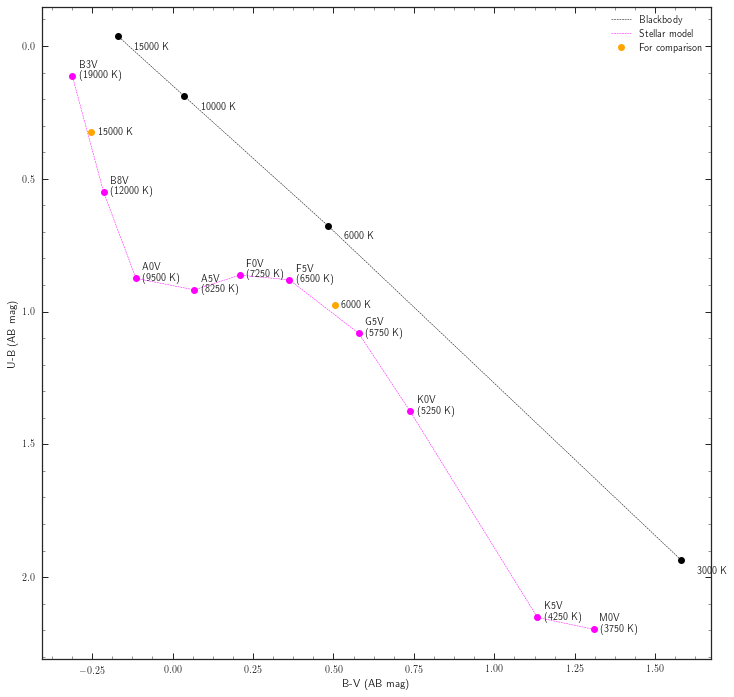

In [75]:
plt.figure(figsize=(12,12))
plt.gca().invert_yaxis()

plt.plot(bv_bb, ub_bb, '--', label='Blackbody', c='black', lw=0.5)
plt.plot(bv_bb, ub_bb, 'o', c='black')

plt.plot(bv_star, ub_star, '--', label = 'Stellar model', c='magenta', lw=0.5)
plt.plot(bv_star, ub_star, 'o', c='magenta')

plt.plot(bv_comp, ub_comp, 'o', c='orange', label='For comparison')

for i in range(len(T)):
    plt.text(bv_bb[i]+0.05, ub_bb[i]+0.05, str(int(T[i]))+' K')

for i in range(len(spec_types)):
    plt.text(bv_star[i]+0.02, ub_star[i]+0.01, spec_types[i]+'\n ('+str(int(temp[i]))+' K)')
    
for i in range(len(tcomp)):
    plt.text(bv_comp[i]+0.02, ub_comp[i]+0.01, tcomp[i]+' K')
    
plt.xlabel('B-V (AB mag)')
plt.ylabel('U-B (AB mag)')
plt.legend()

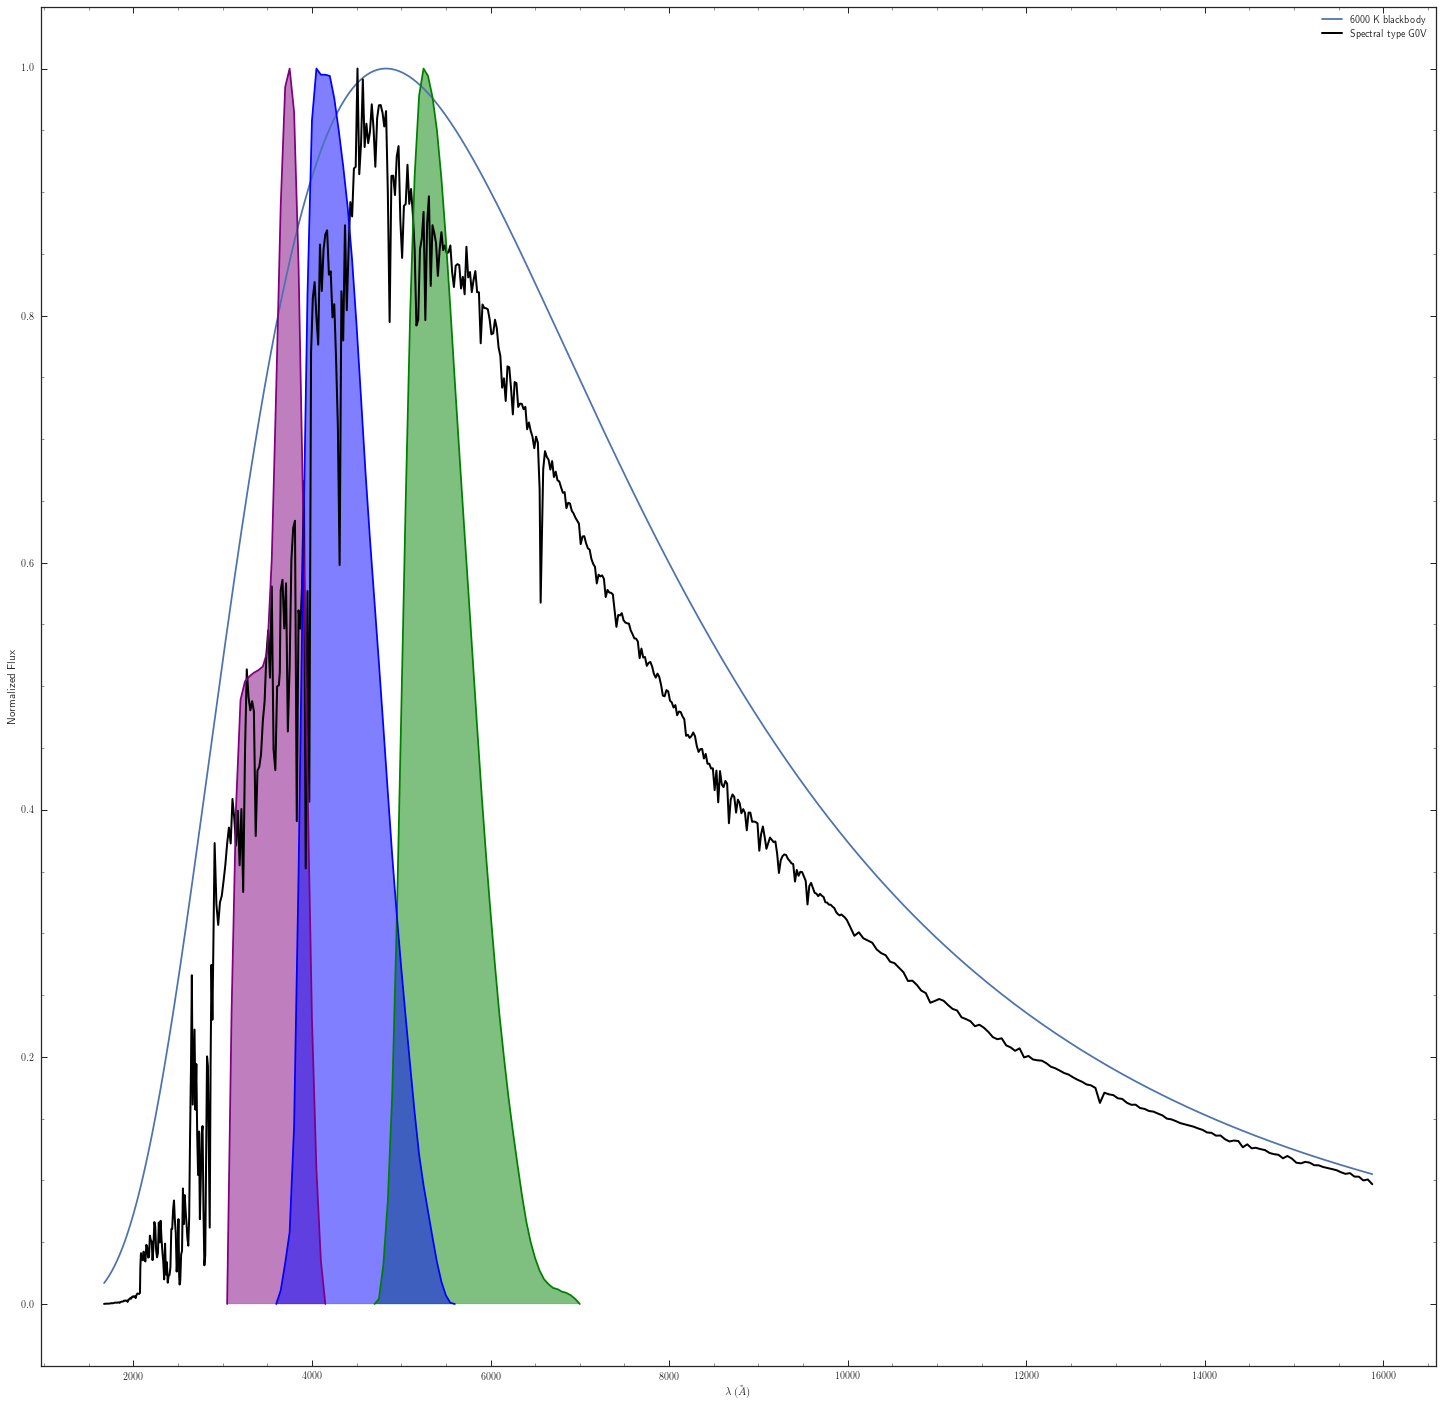

In [107]:
plt.figure(figsize=(25,25))
plt.plot(wavelengths[200:800], bbcurve(wavelengths, 6000)[200:800]/max(bbcurve(wavelengths, 6000)), \
         label='6000 K blackbody')
plt.plot(wavelengths[200:800], star_flux[0][200:800]/max(star_flux[0][200:800]), \
         label='Spectral type G0V', lw = 2, c='k')
plt.plot(lam_u, filteru, color = 'purple')
plt.plot(lam_v, filterv, color = 'green')
plt.plot(lam_b, filterb, color = 'blue')
plt.fill(lam_u, filteru, color='purple', alpha=0.5)
plt.fill(lam_v, filterv, color='green', alpha=0.5)
plt.fill(lam_b, filterb, color='blue', alpha=0.5)
plt.xlabel('$\lambda\; (\AA)$')
plt.ylabel('Normalized Flux')
plt.legend()

In [14]:
#######################################################################
# PROBLEM 3
#######################################################################

In [15]:
dm = [12.37, 16.28]
d = np.array([2.3, 15.6])*(10**3)

In [16]:
def ext(dm, d):
    A = (dm+5) - 5*np.log10(d)
    return A

def colex(av):
    e = av/3.1
    return e

In [17]:
# find extinction coefficient and color excess 
for DM, D in zip(dm,d):
    print(ext(DM, D))
    print(colex(ext(DM, D)))

0.5613608199120321
0.18108413545549423
0.31437700822769443
0.10141193813796594


In [18]:
#######################################################################
# PROBLEM 5
#######################################################################

In [19]:
# given quantities
M = (5*10**11)*(1.989*10**30) # kg 
r = np.array([50*10**3, 200*10**3])*3.1*10**16 # meters 

In [20]:
t_ff1 = np.sqrt((9*((3.142)**2)*r[0]**3)/(8*const.G.value*M))/(3.154e7) # in years
t_ff2 = np.sqrt((9*((3.142)**2)*r[1]**3)/(8*const.G.value*M))/(3.154e7) 

In [21]:
from decimal import Decimal
print('%.2E' % Decimal(str(t_ff1)))
print('%.2E' % Decimal(str(t_ff2)))

7.91E+08
6.33E+09
